In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [ ]:
words = open('names.txt','r').read().splitlines()
words[:9]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper']

In [ ]:
chars = sorted(list(set(''.join(words))))

In [ ]:
chars

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [ ]:
stoi = {s:i+1 for i,s in enumerate(chars)} #i+1 인이유 enumerate의 첫 index - 0이고 이를 시작토큰 .으로 설정
stoi['.'] = 0
itos = {i+1:s for i,s in enumerate(chars)} # {i:s for i,s in stoi.items()} 도 가능
itos[0] = '.'
itos


{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [ ]:
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [ ]:
#데이터셋 만들기
block_size = 3 #context length 몇개의 알파벳을 다음문자를 예측하기 위해 쓸거냐
def build_dataset(words):
  x,y=[],[]
  for w in words:
    context = [0] * block_size
    for ch in w + '.':                #olivia [0,0,0]
      ix =stoi[ch]                    #           o,  l,  i,  v,  i,  a
      x.append(context)               #[[0,0,0]] ...,..o,.ol,oli,liv,iva,...
      y.append(ix)                    #[15] <= olivia 의 stoi가 들어감
      context = context[1:] +[ix]     # 값전달 list
  #build_dataset(words[:3])
  #
  x=torch.tensor(x)
  y=torch.tensor(y)
  print(x.shape,y.shape)

  return x,y

build_dataset(words[:3])



torch.Size([16, 3]) torch.Size([16])


(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13],
         [13, 13,  1],
         [ 0,  0,  0],
         [ 0,  0, 15],
         [ 0, 15, 12],
         [15, 12,  9],
         [12,  9, 22],
         [ 9, 22,  9],
         [22,  9,  1],
         [ 0,  0,  0],
         [ 0,  0,  1],
         [ 0,  1, 22],
         [ 1, 22,  1]]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0]))

In [ ]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

xtr,ytr = build_dataset(words[:n1])
xval, yval = build_dataset(words[n1:n2])
xtest, ytest = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
#                 def__init__():
#---------------------------------------------------------------------------------

n_embedding = 10 #각 단어를 10차원의 벡터로 표현하겟다~
vocab_size = len(itos) # 27
n_hidden = 200 #은닉층에 있는 뉴런개수
g= torch.Generator().manual_seed(2147483647)
#C는 보통 nlp 에서 embedding matrix 의미
C= torch.randn((vocab_size,n_embedding),generator=g)
W1 = torch.randn((n_embedding*block_size,n_hidden), generator= g) # *(5/3)/(n_embedding*block_size)*0.5
#broadcasting 진행 마지막 dim에 더해짐
b1 = torch.randn(n_hidden,generator =g)              #* 0.01  하지만 표준편차도 0.01배됨
W2= torch.randn((n_hidden,vocab_size),generator=g)   #* 0.01
b2 = torch.randn(vocab_size, generator=g)            #* 0

#batchnorm parameter
bngain= torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.ones((1,n_hidden))
bnstd_running = torch.zeros((1,n_hidden))


parameters = [C,W1,b1,W2,b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters))
#27*10 + 30+200 +200 + 200*27 + 27 = 11897
for p in parameters:
  p.requires_grad= True #backpropagation밑밥

11897


In [ ]:
#가우시안 분포 2개 곱하면  |->|   gaussian but std reversible
#std 1로 하는 법  |->|   / fan_in**0.5
#이 경우 w / 10**0.5
#기울기 초기화라고 부름
#기울기 소실 (Vanishing Gradients): 신경망이 깊어질수록, 역전파 알고리즘이 기울기를 전파하면서 기울기가 계속해서 곱해지는 현상이 발생할 수 있습니다. 초기에 작은 표준 편차로 초기화된 가중치들은 여러 층을 거치면서 계속 작아져, 결국 기울기가 거의 소실되어 학습이 어려워지거나 중단되는 문제가 발생할 수 있습니다.
#기울기 폭주 (Exploding Gradients): 반대로 초기에 큰 표준 편차로 초기화된 가중치들은 여러 층을 거치면서 계속 커져, 기울기가 지수적으로 증가하는 현상이 발생할 수 있습니다. 이 경우 가중치 업데이트가 매우 크게 되어 모델의 파라미터가 발산하게 되고, 학습이 불안정해집니다.
#위 두 개 방지

#### FORMULA = GAIN / FAN_IN**0.5

#kaiming normal 이라고 불림
x = torch.randn(1000,10)
w = torch.randn(10,200)   #/ 10**0.5
y=x @ w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,15))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True)


In [ ]:
xtr.shape[0]

In [ ]:
hpreact.mean(0,keepdim=True).shape

In [ ]:
hpreact.std(0,keepdim=True).shape

In [ ]:
max_step = 200000
batch_size = 32
lossi = []

#                 def forward():
#-----------------------------------------------------------
for i in range(max_step):
  ## mini batch 만들기
  #batch size, 하면 size[32]가되고 , 없으면 size[1]이 됨
  idx = torch.randint(0,xtr.shape[0],(batch_size,),generator = g)
  xb,yb = xtr[idx],ytr[idx]
  #xtr shape 16,3 ytr shape 16

  #forward pass

  emb = C[xb]
  # xb shape = 32,3 C shape = 27,10 C가 뭐였냐 -> embedding matrix
  #emb shape = 32,3,10 pytorch의 tensor 에 tensor index 원리? 몰루
  embconcat = emb.view(emb.shape[0],-1)
  # emb.shape[0] = 32 즉 embconcat shape = 32,30

#               linear layer
#--------------------------------------------------------------------------

  hpreact = embconcat @ W1 # + b1  <- useless
  #h_pre_act = hidden layer pre activation
  # 단순히 activition function 전의 hidden layer
  # W1 shape 30,200이였으므로 곱셈가능


#               batchnorm layer -2015 paper-
#                 less decent than layer normalization such as
#---------------------------------------------------------------------------

  bnmeani = hpreact.mean(0,keepdim=True)
  bnstdi = hpreact.std(0,keepdim=True)
  hpreact = (hpreact-bnmeani)/bnstdi
  #tanh(hpreact) 가 0에 가까워져야하며 표준편차 또한 일정해지면 좋다
  #hidden layer마다 normalization을 적용시키면 효율이 극대화되는게 아닌가?
  #-> batch normaliztion comes into play


  bngain= torch.ones((1,n_hidden))
  bnbias = torch.zeros((1,n_hidden))
  hpreact = bngain*hpreact + bnbias
  #but 정규화가 진행됬어도 bell shape의 shift and scale이 있어야 효율이 좋아짐
  #batch normalization gain and batch normalization bias comes into play

  with torch.no_grad():
    bnmean_running = 0.999* bnmean_running + 0.001*bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001*bnstdi
                                            # momentum이라불림 0.001
#---------------------------------------------------------------------------
 #        non-linarity

  h = torch.tanh(hpreact)#activation function
  # W2.shape 200,27
  # hpreact.shape = 32,200
  logits = h @ W2 + b2
  #logits shape 32,27
  #yb shape 32
  loss = F.cross_entropy(logits,yb)
  ###yb = if emma [5,13,13,1]

  #backward pass
  for p in parameters:
    p.grad = None#gradient 초기값없음
  loss.backward()

  #update learnining rate
  lr = 0.1 if i < 100000 else 0.01
  #학습률 조절 초기엔 빠르게 갈수록 안정적으로
  for p in parameters:
    p.data += -lr * p.grad


  # tqdm 모시깽깽이로 진행상황 표시
  if i % 10000 == 0:
    print(f'{i:7d}/{max_step:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break


      0/ 200000: 2.6018


In [ ]:
loss.item()

2.417387008666992

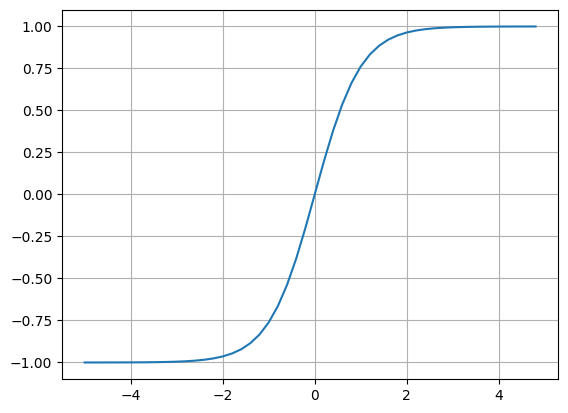

In [ ]:
import numpy as np
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)));plt.grid()

(array([2435.,  141.,   67.,   60.,   57.,   37.,   35.,   18.,   16.,
          15.,   15.,   19.,   13.,   11.,   14.,   11.,    7.,   15.,
          15.,   14.,    9.,   10.,   19.,    8.,   12.,    9.,   12.,
           8.,   13.,    9.,   16.,   14.,    6.,   13.,   11.,    9.,
          16.,   14.,   11.,   20.,   17.,   21.,   31.,   22.,   36.,
          44.,   51.,   88.,  131., 2705.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

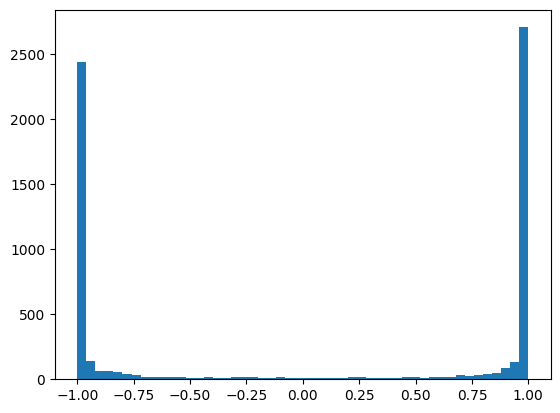

In [ ]:
#매우 좋지 않은 형태의 그래프 tanh 의 derivitive 식은 1-t^^2  * out.grad
#였기 때문에 gradient 없어지고 역전파 x
#tanh 그래프를 생각해보면 쉽게 알수 있다.
#h = tanh(hpreact)이므로 hpreact를 0에 가깝게 만들면 h값도 0에 몰리게 될것이다

#  hpreact = embconcat @ W1 + b1
#  hpreact = embconcat @ W1 * 0.1 + b1 * 0.01

plt.hist(h.view(-1).tolist(),50)

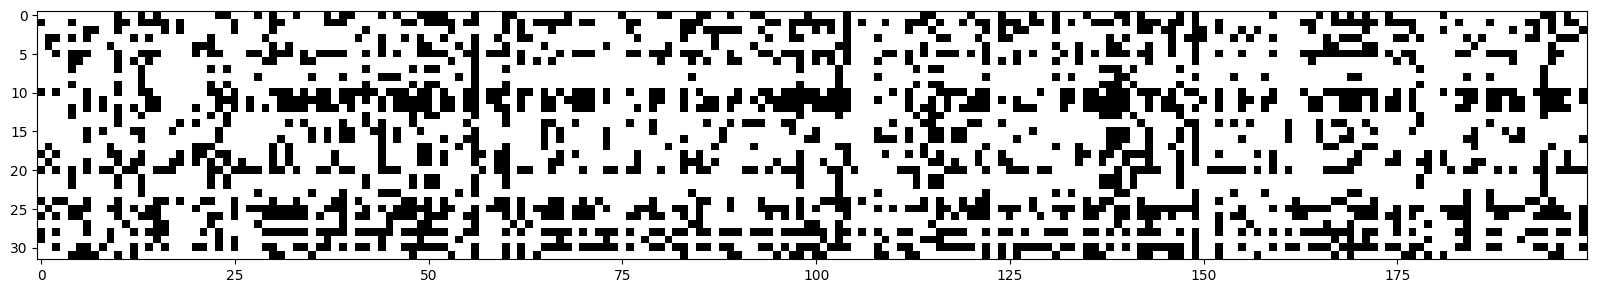

In [ ]:
#white = True which means h값이 1또는 -1  , black = False
#white 는 모두 dead neuron
#sigmoid도 비슷함 vanishing gradient
#relu 는 x>0이상에서는 잘 작동하지만 learning rate가 너무 커서 0이하로 내려가면
#remaining state forever
#혹시 모르니 leaky Relu 와 elu를 쓰자
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

(array([  3.,   1.,   0.,   6.,   5.,  12.,   9.,  20.,  31.,  51.,  66.,
         80.,  90., 131., 130., 200., 212., 286., 355., 409., 410., 351.,
        263., 293., 375., 432., 406., 347., 285., 236., 178., 182., 130.,
        110.,  84.,  64.,  48.,  33.,  28.,  17.,   8.,   5.,   8.,   0.,
          4.,   0.,   0.,   5.,   0.,   1.]),
 array([-22.44412613, -21.45994926, -20.4757724 , -19.49159554,
        -18.50741867, -17.52324181, -16.53906494, -15.55488808,
        -14.57071121, -13.58653435, -12.60235748, -11.61818062,
        -10.63400375,  -9.64982689,  -8.66565002,  -7.68147316,
         -6.6972963 ,  -5.71311943,  -4.72894257,  -3.7447657 ,
         -2.76058884,  -1.77641197,  -0.79223511,   0.19194176,
          1.17611862,   2.16029549,   3.14447235,   4.12864922,
          5.11282608,   6.09700294,   7.08117981,   8.06535667,
          9.04953354,  10.0337104 ,  11.01788727,  12.00206413,
         12.986241  ,  13.97041786,  14.95459473,  15.93877159,
         16.922948

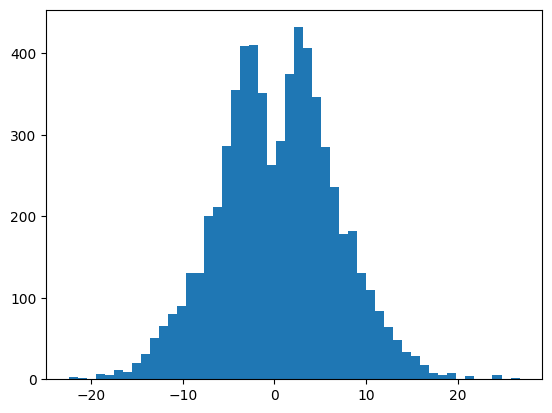

In [ ]:
plt.hist(hpreact.view(-1).tolist(),50)

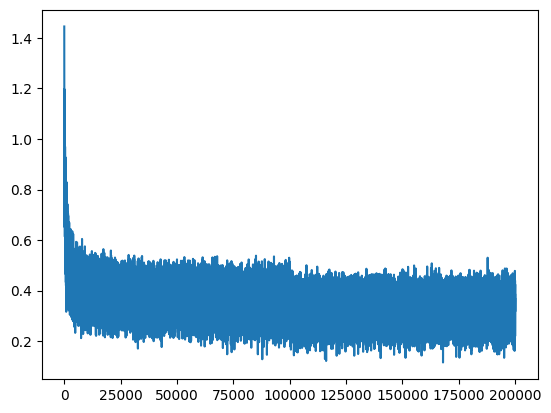

In [ ]:
plt.plot(lossi)
#하키 스틱 모양인데 처음 loss를 줄이면 더 빠르지 않을까?
#logit을 줄이면 됨 logit = h @ w2 + b2 임으로
#                 logit = h @ w2*0.01 + b2*0

In [ ]:
#with torch.no_grad():
 # emb = C[xtr]
 # embcat = emb.view(emb.shape[0],-1)
 # hpreact = emb @ W1 + b1
 # bnmean = hpreact.mean(0,keepdim=True)
 # bnstd = hpreact.std(0,keepdim=True)

#optimizer과 관련 없게 이걸 따로 입력해야 했으나 bnmean_running으로 대체


In [ ]:
@torch.no_grad()
def split_loss(split):
  x,y ={
      'train' : (xtr,ytr),
      'val' : (xval,yval),
      'test' : (xtest,ytest)
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0],-1)
  h= torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 +b2
  loss = F.cross_entropy(logits,y)
  print(split,loss.item())

In [ ]:
#이진욱의 호기심 천국 below

In [ ]:
logit = ([1.0,1.0,1.0,1.0])
# W @ x + b 어떤 데이터에 특징이 더해진 값
probs = F.softmax(logits,dim=0)

In [ ]:
logits.shape

In [ ]:
logits

In [ ]:
yb

In [ ]:
yb.shape

In [ ]:
h.shape

In [ ]:
h

In [ ]:
hpreact.shape

In [ ]:
hpreact

In [ ]:
xb.shape

In [ ]:
emb.shape

In [ ]:
embconcat.shape